<a href="https://colab.research.google.com/github/FrancoCalcia/MDD-TP3/blob/main/TP3_MDD_Avecilla_Calcia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Preparacion del entorno de trabajo

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from matplotlib.colors import LinearSegmentedColormap
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate
from sklearn.metrics import precision_score, recall_score, accuracy_score, make_scorer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import make_scorer, precision_score, recall_score, accuracy_score, classification_report
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV, cross_val_predict
from sklearn.ensemble import RandomForestClassifier

In [2]:
!gdown "1lRNVnPtNNyJe9gRQxHKGDXP5acRV6Tz5" --output "dxWeather.csv"

Downloading...
From: https://drive.google.com/uc?id=1lRNVnPtNNyJe9gRQxHKGDXP5acRV6Tz5
To: /content/dxWeather.csv
100% 516k/516k [00:00<00:00, 72.7MB/s]


## Analisis Descriptivo

In [3]:
df = pd.read_csv("dxWeather.csv")


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10090 entries, 0 to 10089
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Temperatura         10090 non-null  int64  
 1   Humedad             10090 non-null  int64  
 2   VientoVelocidad     10090 non-null  float64
 3   Precipitation       10090 non-null  int64  
 4   PresionAtmosferica  10090 non-null  float64
 5   Localizacion        10090 non-null  object 
 6   TipoClima           10090 non-null  object 
 7   Estacion            10090 non-null  object 
dtypes: float64(2), int64(3), object(3)
memory usage: 630.8+ KB


El DataFrame contiene información meteorológica organizada en 10090 registros y 8 columnas. A continuación, se describen las columnas:

1. **Temperatura**: Representa la temperatura registrada (tipo de dato `int64`).
2. **Humedad**: Indica el porcentaje de humedad (tipo de dato `int64`).
3. **VientoVelocidad**: Velocidad del viento medida (tipo de dato `float64`).
4. **Precipitation**: Cantidad de precipitación registrada (tipo de dato `int64`).
5. **PresionAtmosferica**: Presión atmosférica medida (tipo de dato `float64`).
6. **Localizacion**: Lugar donde se realizaron las mediciones (tipo de dato `object`).
7. **TipoClima**: Categoría del clima en el registro (tipo de dato `object`).
8. **Estacion**: Estación del año correspondiente al registro (tipo de dato `object`).

Todas las columnas están completas y sin valores nulos.

Observemos la distribución de las variables numéricas.

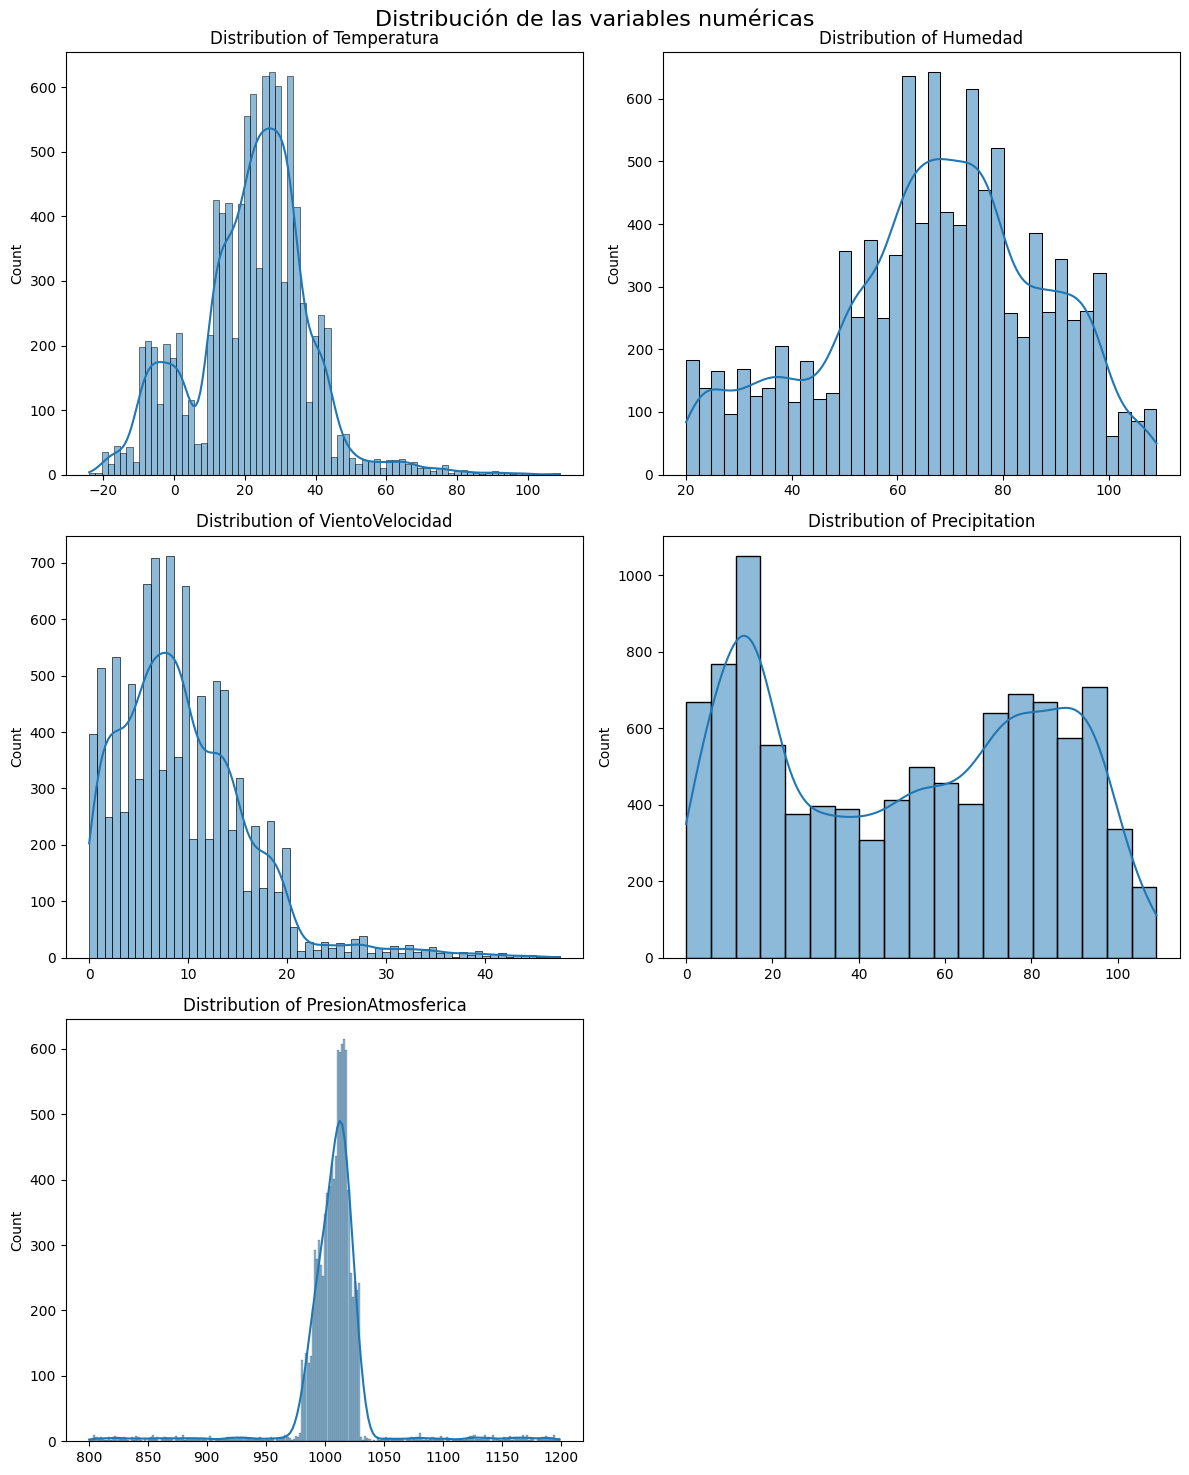

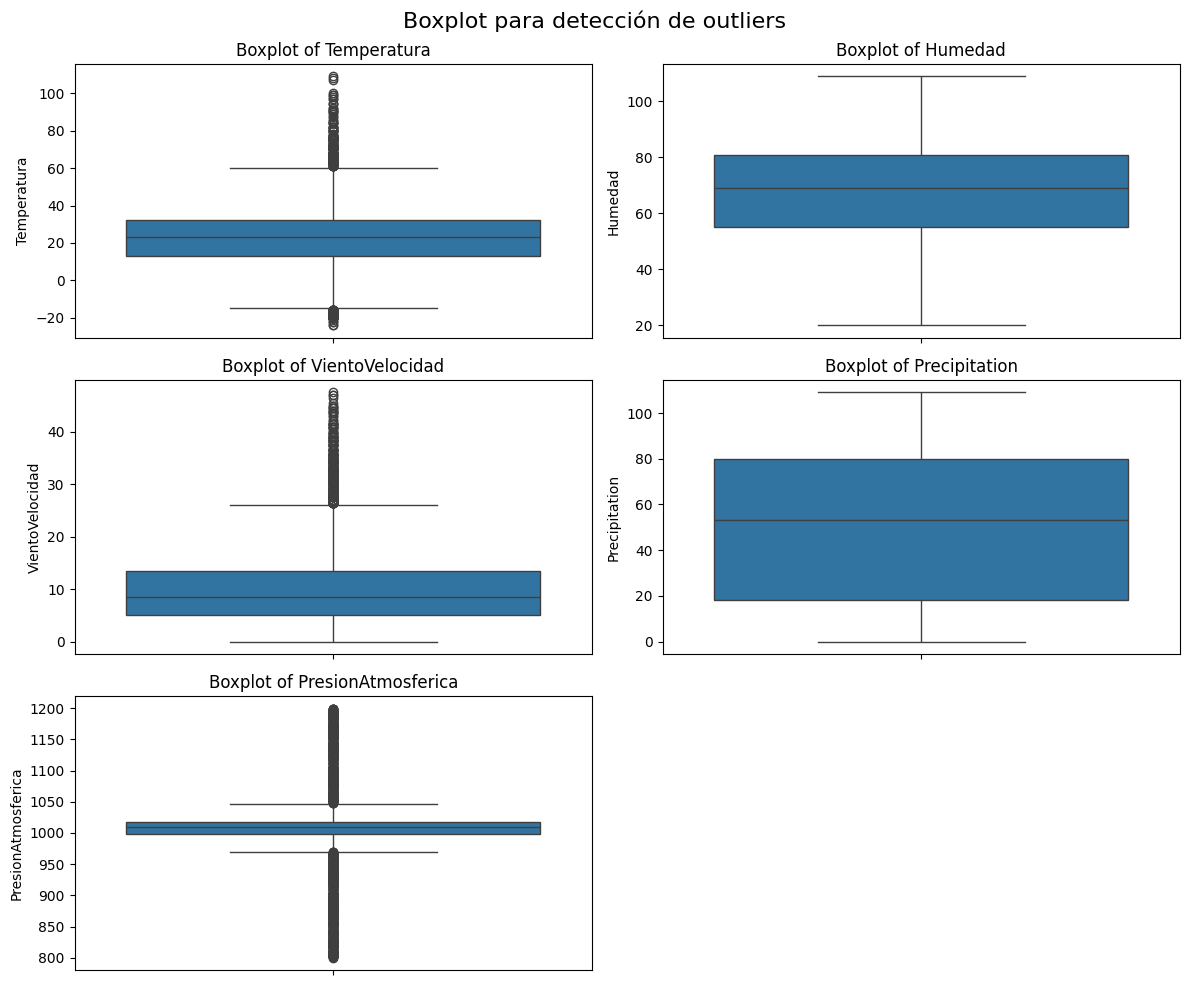

In [5]:
df_numeric = df.select_dtypes(include=['float64', 'int64'])

fig, axes = plt.subplots(3, 2, figsize=(12, 15))
fig.suptitle('Distribución de las variables numéricas', fontsize=16)

for i, col in enumerate(df_numeric.columns):
    sns.histplot(df[col], kde=True, ax=axes[i//2, i%2])
    axes[i//2, i%2].set_title(f'Distribution of {col}')
    axes[i//2, i%2].set_xlabel('')

for j in range(len(df_numeric.columns), 3*2):
    fig.delaxes(axes[j//2, j%2])

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(3, 2, figsize=(12, 10))
fig.suptitle('Boxplot para detección de outliers', fontsize=16)

for i, col in enumerate(df_numeric.columns):
    sns.boxplot(df[col], ax=axes[i//2, i%2])
    axes[i//2, i%2].set_title(f'Boxplot of {col}')
    axes[i//2, i%2].set_xlabel('')

for j in range(len(df_numeric.columns), 3*2):
    fig.delaxes(axes[j//2, j%2])

plt.tight_layout()
plt.show()

1. **Temperatura**:
   - La distribución tiende a ser normal pero ligeramente sesgada hacia la derecha.
   - La mayoría de los valores están concentrados entre los 10°C y los 40°C aproximadamente.
   - Se observan algunos outliers en ambos extremos.

2. **Humedad**:
   - Los valores abarcan desde aproximadamente 20% hasta 100%.
   - Según lo visto en el boxplot, no tenemos valores atípicos.

3. **VientoVelocidad**:
   - La distribución está sesgada hacia la derecha.
   - La mayoría de los registros se encuentran entre 0 y 20 km/h, con pocos valores superiores a él.

4. **Precipitation**:
   - La distribución es más dispersa y parece multimodal.
   - Los valores se distribuyen ampliamente entre 0 y 100 mm, con algunas concentraciones específicas en ciertos intervalos.
   - Sin valores atípicos observados en el boxplot.

5. **PresionAtmosferica**:
   - La distribución es muy concentrada y simétrica, posiblemente ajustándose a una curva normal.
   - Los valores están principalmente entre 950 y 1050 hPa, lo cual es típico para datos de presión atmosférica a nivel del mar.
   - Se pueden observar valores atípicos en el boxplot.


## Análisis Exploratorio

In [6]:
resultados_atipicos = {}

for columna in df.columns:
    if df[columna].dtype in ['int64', 'float64']:
        Q1 = df[columna].quantile(0.25)
        Q3 = df[columna].quantile(0.75)
        IQR = Q3 - Q1

        limite_inferior = Q1 - 1.5 * IQR
        limite_superior = Q3 + 1.5 * IQR

        es_atipico = (df[columna] < limite_inferior) | (df[columna] > limite_superior)

        cantidad_atipicos = es_atipico.sum()
        porcentaje_atipicos = (cantidad_atipicos / len(df)) * 100

        resultados_atipicos[columna] = porcentaje_atipicos

for columna, porcentaje in resultados_atipicos.items():
    print(f"Columna: {columna} - Porcentaje de valores atípicos: {porcentaje:.2f}%")

Columna: Temperatura - Porcentaje de valores atípicos: 2.84%
Columna: Humedad - Porcentaje de valores atípicos: 0.00%
Columna: VientoVelocidad - Porcentaje de valores atípicos: 2.91%
Columna: Precipitation - Porcentaje de valores atípicos: 0.00%
Columna: PresionAtmosferica - Porcentaje de valores atípicos: 8.15%


Si bien en los graficos se puede interpretar que hay muchos valores atipicos, en realidad no es asi. El maximo es presionAtmosferica con un 8.15% que es relativamente bajo. Por lo tanto, no vamos a realizar ninguna limpieza correspondiente.

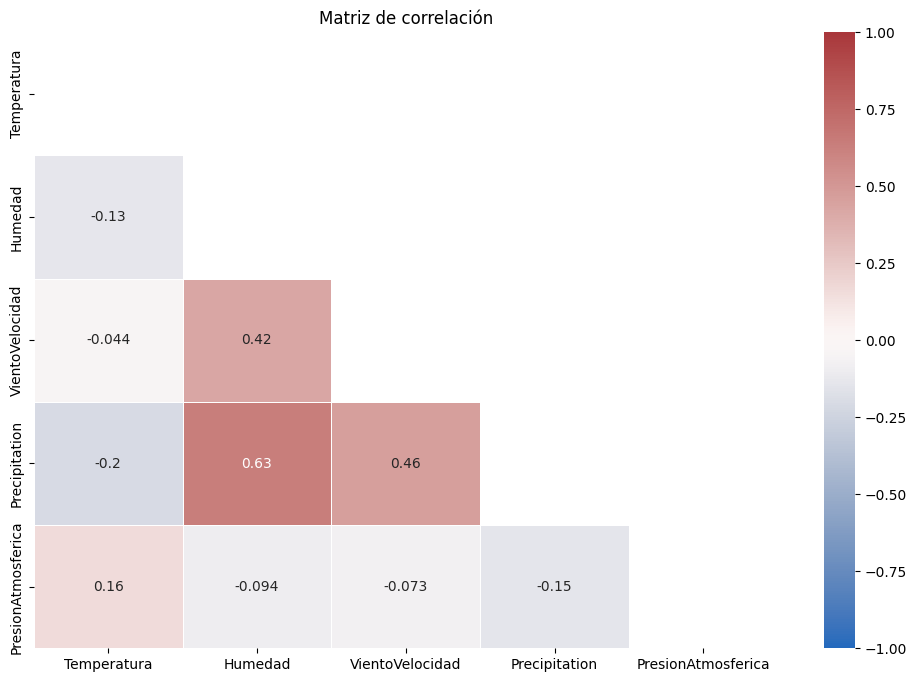

In [7]:
# Calcular la matriz de correlación
corr_matrix = df_numeric.corr()

# Crear la máscara
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Crear el colormap
colors = [(1, 1, 1), (1, 0, 0)]
n_bins = 100
cmap_name = 'red_white'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

# Graficar el heatmap de la matriz de correlación
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='vlag', center=0, vmin=-1, vmax=1, linewidths=0.5)
plt.title('Matriz de correlación')
plt.show()

La correlación entre las variables es generalmente baja, lo que indica que no hay una fuerte relación lineal entre la mayoría de ellas. Sin embargo, la correlación más alta se observa entre las variables **Humedad** y **Precipitación**, lo cual es coherente, ya que tiene sentido físico y meteorológico: a medida que la humedad aumenta, es más probable que se generen condiciones para la precipitación.

Analizaremos las columnas de tipo `object` en nuestro conjunto de datos para evaluar su contenido y determinar la mejor estrategia para transformarlas en variables numéricas, con el objetivo de utilizarlas en futuros modelos predictivos.

In [8]:
df['Localizacion'].unique()

array(['Llanura', 'Montania', 'Costa'], dtype=object)

In [9]:
df['TipoClima'].unique()

array(['Nublado', 'Soleado', 'Nevado', 'Lluvioso'], dtype=object)

In [10]:
df['Estacion'].unique()

array(['Primavera', 'Verano', 'Invierno', 'Otonio'], dtype=object)

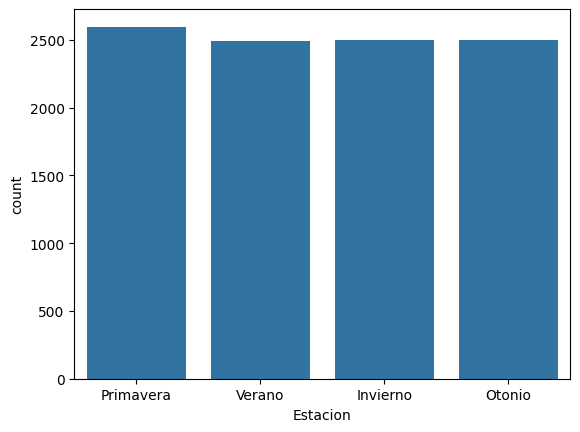

In [11]:
sns.countplot(x='Estacion', data=df)
plt.show()

La variable target se encuentra bastante balanceada, por lo tanto, no aplicaremos ningun metodo para balancearla.

## Limpieza de datos

Simplemente renombramos dos de nuestras columnas.

In [12]:
df.rename(columns={'Precipitation': 'Precipitacion'}, inplace=True)
df.rename(columns={'VientoVelocidad': 'VelocidadViento'}, inplace=True)

In [13]:
df.head()

,Temperatura,Humedad,VelocidadViento,Precipitacion,PresionAtmosferica,Localizacion,TipoClima,Estacion
0,39,96,8.5,71,1011.43,Llanura,Nublado,Primavera
1,30,64,7.0,16,1018.72,Montania,Soleado,Primavera
2,38,83,1.5,82,1026.25,Costa,Soleado,Primavera
3,32,55,3.5,26,1010.03,Llanura,Nublado,Verano
4,3,85,6.0,96,984.46,Llanura,Nevado,Invierno


Aplicaremos **One-Hot Encoding** a las variables de tipo `object` para optimizar su representación y mejorar el desempeño de nuestro modelo.

In [14]:
categorical_columns = df.select_dtypes(include=['object']).columns.difference(['Estacion'])

df_encoded = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

In [15]:
df_encoded

,Temperatura,Humedad,VelocidadViento,Precipitacion,PresionAtmosferica,Estacion,Localizacion_Llanura,Localizacion_Montania,TipoClima_Nevado,TipoClima_Nublado,TipoClima_Soleado
0,39,96,8.5,71,1011.43,Primavera,True,False,False,True,False
1,30,64,7.0,16,1018.72,Primavera,False,True,False,False,True
2,38,83,1.5,82,1026.25,Primavera,False,False,False,False,True
3,32,55,3.5,26,1010.03,Verano,True,False,False,True,False
4,3,85,6.0,96,984.46,Invierno,True,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...
10085,31,24,8.0,5,1029.61,Verano,True,False,False,False,True
10086,29,62,13.0,17,1002.81,Primavera,False,False,False,True,False
10087,10,74,14.5,71,1003.15,Verano,False,True,False,False,False
10088,30,77,5.5,28,1012.69,Otonio,False,False,False,True,False


## Train-Test

In [16]:
X = df_encoded.drop(columns=['Estacion'])
y = df_encoded['Estacion']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8072, 10), (2018, 10), (8072,), (2018,))

Los datos se han dividido correctamente:

- Conjunto de entrenamiento: 8072 muestras.
- Conjunto de prueba: 2018 muestras.
- Número de características: 10 (excluyendo la columna objetivo).

## Escalado

In [17]:
# Aplicamos StandardScaler
scaler = StandardScaler()

# Escalamos la division de datos
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Observamos las primeras 5 filas para verificar el escalado
X_train_scaled[:5]

array([[-2.11162542, -0.09718609,  0.12980091,  0.3445627 , -3.41595861,
        -0.72897066, -0.73256107,  2.29183713, -0.61611138, -0.63412866],
       [-1.2637852 , -0.73003245,  0.57273177, -1.01226418, -4.53132031,
        -0.72897066, -0.73256107, -0.43633118,  1.62308315, -0.63412866],
       [ 0.43189525, -0.82739343,  0.12980091, -1.19728603,  0.16293974,
        -0.72897066,  1.3650739 , -0.43633118,  1.62308315, -0.63412866],
       [-0.47650499,  0.04885538,  0.12980091,  1.05381311, -0.06196858,
        -0.72897066,  1.3650739 , -0.43633118, -0.61611138, -0.63412866],
       [-1.32434521,  1.07114566, -0.46077357,  1.45469378, -0.28254194,
         1.37179733, -0.73256107,  2.29183713, -0.61611138, -0.63412866]])

## SVM - Kernel Lineal

Ahora entrenaremos un modelo de máquina de soporte vectorial (SVM) con kernel lineal y realizaremos validación cruzada con
𝑘
=
5
, evaluando el parámetro de costo
𝐶


In [22]:
# Asegurar que las etiquetas sean NumPy arrays
y_train_array = np.array(y_train)  # Convertir y_train en NumPy array si es necesario

# Definir parámetros para la búsqueda
param_grid = {'C': [0.1, 0.5, 1, 3, 5, 7, 10]}  # Valores del parámetro C
k = 5  # Número de folds para validación cruzada

# Configuración del clasificador SVM
svm_classifier = SVC(kernel='linear')

# Validación cruzada estratificada
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# GridSearchCV para buscar los mejores parámetros con validación cruzada
grid_search = GridSearchCV(estimator=svm_classifier, param_grid=param_grid, cv=skf, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

# Obtener los mejores parámetros
best_params = grid_search.best_params_
print(f"Mejores parámetros encontrados: {best_params}")

# Evaluación del modelo con los mejores parámetros
svm_best = grid_search.best_estimator_

# Validación cruzada manual para evaluar cada fold por separado
fold_results = []  # Para guardar métricas de cada fold

print(f"\nEvaluación individual de cada fold (k = {k}):")
for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X_train_scaled, y_train_array), start=1):
    # Dividir los datos en entrenamiento y validación
    X_train_fold, X_val_fold = X_train_scaled[train_idx], X_train_scaled[val_idx]
    y_train_fold, y_val_fold = y_train_array[train_idx], y_train_array[val_idx]

    # Entrenar el modelo con los datos del fold
    svm_best.fit(X_train_fold, y_train_fold)
    y_pred_fold = svm_best.predict(X_val_fold)

    # Calcular métricas para este fold
    accuracy_fold = accuracy_score(y_val_fold, y_pred_fold)
    precision_fold = precision_score(y_val_fold, y_pred_fold, average='macro')
    recall_fold = recall_score(y_val_fold, y_pred_fold, average='macro')

    # Guardar resultados del fold
    fold_results.append((accuracy_fold, precision_fold, recall_fold))

    # Imprimir resultados del fold actual
    print(f"  Fold {fold_idx}:")
    print(f"    Accuracy: {accuracy_fold * 100:.2f}%")
    print(f"    Precision: {precision_fold * 100:.2f}%")
    print(f"    Recall: {recall_fold * 100:.2f}%")
    print("-" * 40)

# Calcular métricas promedio de todos los folds
accuracy_mean = np.mean([result[0] for result in fold_results])
precision_mean = np.mean([result[1] for result in fold_results])
recall_mean = np.mean([result[2] for result in fold_results])

print("\nResultados promedio en validación cruzada:")
print(f"  Accuracy promedio: {accuracy_mean * 100:.2f}%")
print(f"  Precision promedio: {precision_mean * 100:.2f}%")
print(f"  Recall promedio: {recall_mean * 100:.2f}%")

# Evaluación en el conjunto de prueba
svm_best.fit(X_train_scaled, y_train_array)
y_pred_test = svm_best.predict(X_test_scaled)

accuracy_test = accuracy_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test, average='macro')
recall_test = recall_score(y_test, y_pred_test, average='macro')

print("\nResultados en el conjunto de prueba:")
print(f"  Accuracy: {accuracy_test * 100:.2f}%")
print(f"  Precision: {precision_test * 100:.2f}%")
print(f"  Recall: {recall_test * 100:.2f}%")

print("\nReporte de clasificación en el conjunto de prueba:")
print(classification_report(y_test, y_pred_test))


Mejores parámetros encontrados: {'C': 1}

Evaluación individual de cada fold (k = 5):
  Fold 1:
    Accuracy: 37.59%
    Precision: 42.77%
    Recall: 37.52%
----------------------------------------
  Fold 2:
    Accuracy: 40.06%
    Precision: 45.29%
    Recall: 39.95%
----------------------------------------
  Fold 3:
    Accuracy: 37.17%
    Precision: 42.64%
    Recall: 36.91%
----------------------------------------
  Fold 4:
    Accuracy: 37.79%
    Precision: 42.68%
    Recall: 37.77%
----------------------------------------
  Fold 5:
    Accuracy: 38.35%
    Precision: 43.17%
    Recall: 38.52%
----------------------------------------

Resultados promedio en validación cruzada:
  Accuracy promedio: 38.19%
  Precision promedio: 43.31%
  Recall promedio: 38.13%

Resultados en el conjunto de prueba:
  Accuracy: 38.16%
  Precision: 43.99%
  Recall: 38.21%

Reporte de clasificación en el conjunto de prueba:
              precision    recall  f1-score   support

    Invierno       0.

### Interpretación de Resultados

En el análisis realizado utilizando un modelo de clasificación con **SVM (Support Vector Machine con Kernel Lineal)**, se evaluaron los resultados en cada uno de los *folds* de la validación cruzada (k=5) y en el conjunto de prueba final. A continuación se presenta una interpretación detallada de los resultados:

---

#### **Mejores parámetros encontrados**
El proceso de **GridSearchCV** identificó que el valor óptimo del hiperparámetro `C` es **1**, lo que indica que un equilibrio moderado entre la penalización de errores y la maximización del margen es adecuado para este modelo.


---
#### **Resultados en validación cruzada**
Durante la validación cruzada con k=5, el modelo fue evaluado en cada partición del conjunto de datos, obteniendo métricas individuales para cada *fold*. Los resultados promedio de las métricas clave son:

- **Exactitud promedio (Accuracy):** 38.19%  
  Indica que el modelo clasificó correctamente el 38.19% de las instancias durante la validación cruzada. Esto refleja un rendimiento bajo, posiblemente influido por una alta complejidad o poca separabilidad entre las clases.

- **Precisión promedio (Precision):** 43.31%  
  Aunque es ligeramente mejor que la exactitud, su valor sigue siendo bajo, lo que señala dificultad en la discriminación de clases específicas.

- **Exhaustividad promedio (Recall):** 38.13%  
  Su similitud con la exactitud refuerza la hipótesis de un rendimiento general limitado.

La variabilidad entre los *folds* es baja, con resultados consistentes pero igualmente bajos en cada uno de ellos.

---

#### **Resultados en el conjunto de prueba**
Al evaluar el modelo con los mejores hiperparámetros en el conjunto de prueba, se obtuvieron las siguientes métricas:

- **Exactitud:** 38.16%  
  Similar al promedio de la validación cruzada, indicando que el modelo generaliza de manera consistente pero con bajo rendimiento.

- **Precisión ponderada:** 43.99%  
  Ligeramente superior a la de la validación cruzada, lo que podría deberse a una distribución particular de clases en el conjunto de prueba.

- **Exhaustividad ponderada:** 38.21%  
  Muy cercana a la obtenida durante la validación cruzada, sugiriendo consistencia en la identificación de las instancias.
---

#### **Reporte de clasificación en el conjunto de prueba**
El análisis por clase muestra las siguientes observaciones:

1. **Clase "Invierno":**  
   - **Precisión (89%):** Es la clase más fácil de identificar, con un alto porcentaje de predicciones correctas.
   - **Exhaustividad (56%):** Sin embargo, no todas las instancias de "Invierno" fueron detectadas, indicando un problema con los falsos negativos.

2. **Clase "Otoño":**  
   - **Precisión (27%) y Recall (32%):** Muestran que el modelo tiene serias dificultades para identificar correctamente esta clase, probablemente por confusión con otras estaciones.

3. **Clase "Primavera":**  
   - **Precisión (31%) y Recall (33%):** Resultados bajos que reflejan una confusión significativa con otras clases.

4. **Clase "Verano":**  
   - **Precisión (29%) y Recall (33%):** Similar a "Primavera", con un desempeño pobre en esta clase.

La clase "Invierno" domina el desempeño global, pero las demás clases presentan un rendimiento muy deficiente, lo que sugiere que las características de estas clases no son suficientemente separables con este modelo.

---

#### **Conclusiones**
1. **Rendimiento general bajo:** Con una exactitud del 38.16%, el modelo tiene un desempeño limitado y apenas supera el azar en un problema de clasificación multiclase con 4 clases.
   
2. **Dominio de una clase:** La clase "Invierno" tiene un rendimiento significativamente mejor que las otras.







## SVM - Kernel Gaussiano

In [24]:
# Definir el modelo SVM con kernel RBF
svm_rbf = SVC(kernel='rbf', random_state=42, max_iter=10000)

# Configuración de hiperparámetros para GridSearchCV
param_grid = {
    'C': [0.1, 0.5, 1, 3, 5, 7, 10],  # Valores de costo
    'gamma': [0.01, 0.1, 0.5, 1, 3, 5, 7, 10]  # Valores de gamma
}

# Validación cruzada con k=5
k = 5
cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# Búsqueda de hiperparámetros con GridSearchCV
grid_search = GridSearchCV(estimator=svm_rbf, param_grid=param_grid, cv=cv, scoring='accuracy', verbose=1)
grid_search.fit(X_train_scaled, y_train)

# Mejor modelo encontrado
best_params = grid_search.best_params_
print("\nMejores hiperparámetros:")
print(best_params)

# Evaluación manual para cada fold utilizando los mejores hiperparámetros
svm_best = SVC(kernel='rbf', random_state=42, max_iter=25000, **best_params)
fold_results = []  # Para guardar métricas de cada fold

print(f"\nEvaluación individual de cada fold (k = {k}):")
for fold_idx, (train_idx, val_idx) in enumerate(cv.split(X_train_scaled, y_train), start=1):
    # Dividir los datos en entrenamiento y validación
    X_train_fold, X_val_fold = X_train_scaled[train_idx], X_train_scaled[val_idx]
    y_train_fold, y_val_fold = np.array(y_train)[train_idx], np.array(y_train)[val_idx]

    # Entrenar el modelo con los datos del fold
    svm_best.fit(X_train_fold, y_train_fold)
    y_pred_fold = svm_best.predict(X_val_fold)

    # Calcular métricas para este fold
    accuracy_fold = accuracy_score(y_val_fold, y_pred_fold)
    precision_fold = precision_score(y_val_fold, y_pred_fold, average='macro')
    recall_fold = recall_score(y_val_fold, y_pred_fold, average='macro')

    # Guardar resultados del fold
    fold_results.append((accuracy_fold, precision_fold, recall_fold))

    # Imprimir resultados del fold actual
    print(f"  Fold {fold_idx}:")
    print(f"    Accuracy: {accuracy_fold * 100:.2f}%")
    print(f"    Precision: {precision_fold * 100:.2f}%")
    print(f"    Recall: {recall_fold * 100:.2f}%")
    print("-" * 40)

# Calcular métricas promedio de todos los folds
accuracy_mean = np.mean([result[0] for result in fold_results])
precision_mean = np.mean([result[1] for result in fold_results])
recall_mean = np.mean([result[2] for result in fold_results])

print("\nResultados promedio en validación cruzada:")
print(f"  Accuracy promedio: {accuracy_mean * 100:.2f}%")
print(f"  Precision promedio: {precision_mean * 100:.2f}%")
print(f"  Recall promedio: {recall_mean * 100:.2f}%")

# Evaluación en el conjunto de prueba
svm_best.fit(X_train_scaled, y_train)
y_pred_test = svm_best.predict(X_test_scaled)

accuracy_test = accuracy_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test, average='macro')
recall_test = recall_score(y_test, y_pred_test, average='macro')

print("\nResultados en el conjunto de prueba:")
print(f"  Accuracy: {accuracy_test * 100:.2f}%")
print(f"  Precision: {precision_test * 100:.2f}%")
print(f"  Recall: {recall_test * 100:.2f}%")

print("\nReporte de clasificación en el conjunto de prueba:")
print(classification_report(y_test, y_pred_test))


Fitting 5 folds for each of 56 candidates, totalling 280 fits


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Con


Mejores hiperparámetros:
{'C': 1, 'gamma': 1}

Evaluación individual de cada fold (k = 5):
  Fold 1:
    Accuracy: 38.14%
    Precision: 46.37%
    Recall: 38.12%
----------------------------------------
  Fold 2:
    Accuracy: 40.87%
    Precision: 47.46%
    Recall: 40.79%
----------------------------------------
  Fold 3:
    Accuracy: 40.52%
    Precision: 48.33%
    Recall: 40.47%
----------------------------------------
  Fold 4:
    Accuracy: 40.15%
    Precision: 47.22%
    Recall: 40.10%
----------------------------------------
  Fold 5:
    Accuracy: 39.16%
    Precision: 46.57%
    Recall: 39.10%
----------------------------------------

Resultados promedio en validación cruzada:
  Accuracy promedio: 39.77%
  Precision promedio: 47.19%
  Recall promedio: 39.72%

Resultados en el conjunto de prueba:
  Accuracy: 38.90%
  Precision: 46.40%
  Recall: 38.87%

Reporte de clasificación en el conjunto de prueba:
              precision    recall  f1-score   support

    Invierno   

### Interpretación de Resultados: SVM con Kernel Gaussiano

Se evaluó un modelo de **SVM con kernel gaussiano (RBF)**, optimizando los hiperparámetros `C` y `gamma` mediante **GridSearchCV** y utilizando validación cruzada (k=5). A continuación, se presentan los hallazgos clave:

---

#### **Mejores hiperparámetros encontrados**
El proceso de búsqueda identificó los valores óptimos:
- **C:** 1  
  Un valor bajo que sugiere una penalización moderada de los errores en el margen, equilibrando simplicidad y precisión.
- **Gamma:** 1  
  Un valor intermedio que controla el alcance de influencia de los puntos de datos individuales, permitiendo capturar relaciones no lineales sin sobreajustar.

---

#### **Resultados en validación cruzada**
Los resultados promedio obtenidos en los 5 *folds* de la validación cruzada muestran:

- **Exactitud promedio (Accuracy):** 39.77%  
  Representa el porcentaje de instancias clasificadas correctamente. Aunque es ligeramente mejor que en el SVM con kernel lineal, el modelo aún no supera significativamente el azar.

- **Precisión promedio (Precision):** 47.19%  
  Indica que el modelo tiene un desempeño algo mejor en evitar falsos positivos, ponderado por el número de instancias en cada clase.

- **Exhaustividad promedio (Recall):** 39.72%  
  Refleja la capacidad del modelo para identificar correctamente las instancias de cada clase.

La consistencia de los resultados entre los *folds* sugiere que el modelo generaliza de manera estable, aunque su rendimiento global es limitado.

---

#### **Resultados en el conjunto de prueba**
Al evaluar el modelo con los mejores hiperparámetros en el conjunto de prueba, se obtuvieron los siguientes resultados:

- **Exactitud:** 38.90%  
  Similar al promedio en validación cruzada, mostrando que el modelo generaliza bien pero sigue siendo poco efectivo.

- **Precisión ponderada:** 46.40%  
  En línea con los resultados de la validación cruzada, aunque levemente menor.

- **Exhaustividad ponderada:** 38.87%  
  Refuerza la idea de un desempeño estable pero limitado.

---

#### **Reporte de clasificación en el conjunto de prueba**
El análisis por clase destaca los siguientes puntos:

1. **Clase "Invierno":**
   - **Precisión (98%):** Muy alta, indicando que el modelo rara vez clasifica incorrectamente instancias de esta clase.
   - **Exhaustividad (55%):** Sin embargo, solo identifica algo más de la mitad de las instancias de "Invierno", lo que indica falsos negativos significativos.

2. **Clase "Otoño":**
   - **Precisión (30%) y Recall (33%):** Resultados bajos, con un rendimiento similar al del modelo lineal.

3. **Clase "Primavera":**
   - **Precisión (30%) y Recall (41%):** Aunque la precisión es baja, la capacidad de detectar instancias de esta clase (recall) mejoró ligeramente en comparación con el modelo lineal.

4. **Clase "Verano":**
   - **Precisión (28%) y Recall (26%):** Es la clase con peor rendimiento, posiblemente debido a una mayor confusión con otras estaciones.

El **f1-score** promedio ponderado (41%) refleja el equilibrio entre precisión y recall, indicando que el modelo tiene dificultades significativas en clases más confusas como "Otoño" y "Verano".

---

#### **Conclusiones**
1. **Mejor rendimiento que el modelo lineal:** El kernel gaussiano logra un leve aumento en precisión promedio (47.19% frente a 43.31%) y recall promedio (39.72% frente a 38.13%), lo que indica que la introducción de relaciones no lineales mejora ligeramente el desempeño.

2. **Dominio de la clase "Invierno":** Similar al modelo lineal, el modelo tiene un sesgo hacia esta clase, clasificándola correctamente con mayor frecuencia que las otras.

3. **Limitaciones globales:**  
   - El modelo tiene problemas significativos para diferenciar entre las clases "Otoño", "Primavera" y "Verano".
   - La similitud de los resultados con el modelo lineal sugiere que los datos pueden no tener patrones suficientemente complejos o distintivos para que el kernel gaussiano brinde una ventaja sustancial.



## Random Forest

In [25]:
# Configuración de hiperparámetros para GridSearchCV
param_grid = {
    'n_estimators': [50, 150, 200, 500],
    'max_features': [3, 5, 6, 7, 9],
    'max_depth': [6, 9, 10, 11],
    'random_state': [18]
}

# Validación cruzada con k=5
k = 5
cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# Configurar el clasificador Random Forest
rf = RandomForestClassifier(random_state=42)

# Búsqueda de hiperparámetros con GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=cv, scoring='accuracy', verbose=1)
grid_search.fit(X_train_scaled, y_train)

# Mostrar los mejores parámetros encontrados
best_params = grid_search.best_params_
print("\nMejores parámetros encontrados:", best_params)

# Configurar el modelo con los mejores parámetros
best_rf = RandomForestClassifier(**best_params)

# Evaluación manual para cada fold
fold_results = []  # Para guardar métricas de cada fold
print(f"\nEvaluación individual de cada fold (k = {k}):")
for fold_idx, (train_idx, val_idx) in enumerate(cv.split(X_train_scaled, y_train), start=1):
    # Dividir los datos en entrenamiento y validación
    X_train_fold, X_val_fold = X_train_scaled[train_idx], X_train_scaled[val_idx]
    y_train_fold, y_val_fold = np.array(y_train)[train_idx], np.array(y_train)[val_idx]

    # Entrenar el modelo con los datos del fold
    best_rf.fit(X_train_fold, y_train_fold)
    y_pred_fold = best_rf.predict(X_val_fold)

    # Calcular métricas para este fold
    accuracy_fold = accuracy_score(y_val_fold, y_pred_fold)
    precision_fold = precision_score(y_val_fold, y_pred_fold, average='weighted')
    recall_fold = recall_score(y_val_fold, y_pred_fold, average='weighted')

    # Guardar resultados del fold
    fold_results.append((accuracy_fold, precision_fold, recall_fold))

    # Imprimir resultados del fold actual
    print(f"  Fold {fold_idx}:")
    print(f"    Accuracy: {accuracy_fold * 100:.2f}%")
    print(f"    Precision: {precision_fold * 100:.2f}%")
    print(f"    Recall: {recall_fold * 100:.2f}%")
    print("-" * 40)

# Calcular métricas promedio de todos los folds
accuracy_mean = np.mean([result[0] for result in fold_results])
precision_mean = np.mean([result[1] for result in fold_results])
recall_mean = np.mean([result[2] for result in fold_results])

print("\nResultados promedio en validación cruzada:")
print(f"  Accuracy promedio: {accuracy_mean * 100:.2f}%")
print(f"  Precision promedio: {precision_mean * 100:.2f}%")
print(f"  Recall promedio: {recall_mean * 100:.2f}%")

# Evaluación en el conjunto de prueba
best_rf.fit(X_train_scaled, y_train)
y_pred_test = best_rf.predict(X_test_scaled)

accuracy_test = accuracy_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test, average='weighted')
recall_test = recall_score(y_test, y_pred_test, average='weighted')

print("\nResultados en el conjunto de prueba:")
print(f"  Accuracy: {accuracy_test * 100:.2f}%")
print(f"  Precision: {precision_test * 100:.2f}%")
print(f"  Recall: {recall_test * 100:.2f}%")

print("\nReporte de clasificación en el conjunto de prueba:")
print(classification_report(y_test, y_pred_test))


Fitting 5 folds for each of 80 candidates, totalling 400 fits

Mejores parámetros encontrados: {'max_depth': 9, 'max_features': 6, 'n_estimators': 150, 'random_state': 18}

Evaluación individual de cada fold (k = 5):
  Fold 1:
    Accuracy: 37.89%
    Precision: 45.85%
    Recall: 37.89%
----------------------------------------
  Fold 2:
    Accuracy: 39.75%
    Precision: 46.94%
    Recall: 39.75%
----------------------------------------
  Fold 3:
    Accuracy: 38.41%
    Precision: 46.27%
    Recall: 38.41%
----------------------------------------
  Fold 4:
    Accuracy: 39.34%
    Precision: 46.21%
    Recall: 39.34%
----------------------------------------
  Fold 5:
    Accuracy: 38.17%
    Precision: 45.76%
    Recall: 38.17%
----------------------------------------

Resultados promedio en validación cruzada:
  Accuracy promedio: 38.71%
  Precision promedio: 46.20%
  Recall promedio: 38.71%

Resultados en el conjunto de prueba:
  Accuracy: 38.40%
  Precision: 46.12%
  Recall: 38.4

### Interpretación de Resultados: Random Forest

Se evaluó un modelo de **Random Forest** con los hiperparámetros optimizados utilizando **GridSearchCV**. Los mejores parámetros encontrados fueron:

- **n_estimators:** 150  
- **max_depth:** 9  
- **max_features:** 6  
- **random_state:** 18  

El modelo fue evaluado mediante validación cruzada con 5 *folds* y también se evaluó en el conjunto de prueba.

---

#### **Mejores hiperparámetros encontrados**
Los valores óptimos para el modelo fueron:
- **n_estimators (número de árboles):** 150  
  Un valor intermedio que proporciona un equilibrio entre la complejidad del modelo y el tiempo de cómputo.
- **max_depth (profundidad máxima de los árboles):** 9  
  Limita la profundidad de cada árbol, lo que ayuda a evitar el sobreajuste al limitar la complejidad de los modelos base.
- **max_features (número de características a considerar para cada árbol):** 6  
  Esto restringe la cantidad de características disponibles para cada división, lo que ayuda a reducir la varianza y mejorar la generalización.

---

#### **Resultados en validación cruzada**
Los resultados promedio obtenidos en los 5 *folds* de la validación cruzada muestran:

- **Exactitud promedio (Accuracy):** 38.71%  
  El modelo tiene un desempeño similar al del SVM con kernel gaussiano. Aunque la precisión es algo mayor que la de modelos más simples, sigue estando lejos de ser ideal.

- **Precisión promedio (Precision):** 46.20%  
  La precisión promedio indica que el modelo tiene un desempeño relativamente alto para evitar falsos positivos en la clasificación.

- **Exhaustividad promedio (Recall):** 38.71%  
  Similar a la exactitud, lo que indica que el modelo es capaz de identificar correctamente instancias en la mayoría de los casos, pero aún tiene margen de mejora.

---

#### **Resultados en el conjunto de prueba**
Cuando se evalúa el modelo con los mejores hiperparámetros en el conjunto de prueba, se obtienen los siguientes resultados:

- **Exactitud:** 38.40%  
  Similar a la exactitud promedio en validación cruzada, lo que confirma que el modelo es consistente pero limitado en su capacidad de generalización.

- **Precisión ponderada:** 46.12%  
  Pese a ser ligeramente inferior a la precisión promedio en validación cruzada, se mantiene en un nivel razonablemente alto, indicando una baja tasa de falsos positivos.

- **Exhaustividad ponderada:** 38.40%  
  Es consistentemente baja, lo que sugiere que el modelo tiene dificultades para identificar correctamente las instancias de todas las clases.

---

#### **Reporte de clasificación en el conjunto de prueba**
El análisis de las clases individuales muestra lo siguiente:

1. **Clase "Invierno":**
   - **Precisión (1.00):** Perfecta, indicando que el modelo clasifica correctamente todas las instancias de "Invierno".
   - **Exhaustividad (55%):** Aunque clasifica correctamente todas las instancias de "Invierno", aún hay una alta tasa de falsos negativos, ya que no detecta todas las instancias de esta clase.

2. **Clase "Otoño":**
   - **Precisión (26%) y Recall (23%):** Resultados bajos, reflejando una difícil clasificación para esta clase, con muchos falsos positivos y falsos negativos.

3. **Clase "Primavera":**
   - **Precisión (29%) y Recall (45%):** Aunque la precisión es baja, el modelo tiene una mejor capacidad para identificar instancias de esta clase (recall), lo que indica menos falsos negativos.

4. **Clase "Verano":**
   - **Precisión (30%) y Recall (30%):** Similar a "Primavera", el rendimiento es limitado, con una tasa de falsos positivos y falsos negativos bastante alta.

El **f1-score** promedio ponderado (40%) refleja el balance entre precisión y recall, destacando que el modelo tiene dificultades para identificar correctamente las clases "Otoño" y "Primavera", y realiza una clasificación más precisa de "Invierno".

---

#### **Conclusiones**
1. **Mejor rendimiento que el modelo SVM con kernel gaussiano:** El Random Forest logró una mejora ligera en comparación con el SVM, pero aún muestra un rendimiento limitado en cuanto a la generalización.

2. **Dominio de la clase "Invierno":** Al igual que con el modelo SVM, el modelo de Random Forest tiene un sesgo hacia la clase "Invierno", clasificando esta clase con alta precisión, pero con recall moderado.

3. **Desempeño limitado en "Otoño", "Primavera" y "Verano":** Las clases "Otoño" y "Verano" continúan siendo problemáticas, con bajas precisiones y recalls, lo que sugiere que hay mucha confusión entre estas clases.


En resumen, el Random Forest mostró resultados consistentes, aunque sigue presentando dificultades para manejar ciertas clases, especialmente las menos representadas en el conjunto de datos.

## Conclusión Global para los Modelos Evaluados (SVM con kernel Gaussiano, SVM con kernel RBF y Random Forest)

A partir de los resultados obtenidos para los tres modelos evaluados, se puede concluir lo siguiente:

#### 1. **Rendimiento General**:
   - Los tres modelos muestran un rendimiento similar en términos de **exactitud** (rondando entre el 38% y el 39%). Aunque estos valores no son especialmente altos, indican que los modelos tienen un rendimiento ligeramente superior al azar, pero aún presentan importantes limitaciones en su capacidad para generalizar y clasificar correctamente las clases.
   - La **precisión** promedio es más apenas alta, especialmente en el SVM con kernel Gaussiano y Random Forest, lo que sugiere que estos modelos están evitando en gran medida los falsos positivos. Sin embargo, la **exhaustividad (recall)** sigue siendo baja, especialmente para las clases "Otoño" y "Verano", lo que indica que los modelos tienen dificultades para identificar correctamente todas las instancias de esas clases.

#### 2. **Mejor Modelo**:
   - Si bien las métricas son bajas en todos los modelos, el **Random Forest** parece ser el modelo con un desempeño ligeramente más robusto, debido a su capacidad para manejar la diversidad de los datos con varios árboles y características aleatorias. Este modelo presenta una precisión constante y una capacidad de generalización algo mejor que los modelos SVM, especialmente en la clase "Invierno", que es la que está mejor representada.
   - El **SVM con kernel Gaussiano** muestra un desempeño más estable en términos de precisión, pero también enfrenta dificultades al identificar las clases menos representadas.
   - El **SVM con kernel RBF** tiene resultados similares al SVM Gaussiano, con un rendimiento algo más bajo en recall.

#### 3. **Desempeño en las Clases**:
   - Todos los modelos muestran una clara **dificultad en clasificar las clases menos representadas** (especialmente "Otoño" y "Verano"). Estas clases tienen **bajas puntuaciones de precisión y recall**.
   - Las clases más representadas, como **"Invierno"**, muestran un buen desempeño, con altos valores de precisión, pero con **recall moderado**, lo que sugiere que algunos modelos podrían estar sobreajustando a las clases dominantes.


Aunque ninguno de los modelos probados logra un rendimiento sobresaliente, el Random Forest muestra el mejor desempeño global, seguido de cerca por los modelos SVM.